## Movielens Project

The goal of this MovieLens Project is to create a movie recommendation model able to predict movie ratings with a root mean squared error (RMSE) of less than 0.86490 compared to actual movie ratings. Data is sourced from the MovieLens dataset and divided into two datasets, each containing the variables userId, movieId, rating, timestamp, title, and genres:

•	train, with approximately 9 million observations.

•	validation, with about 1 million observations.


 

## Download the dataset and split

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split , cross_val_score
import requests
from io import BytesIO
from zipfile import ZipFile
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import re
import datetime
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


# Download movielens 

response = requests.get("https://files.grouplens.org/datasets/movielens/ml-10m.zip")
zip_file = ZipFile(BytesIO(response.content))
zip_file.extractall('data/')  

# Read and process ratings 
ratings = pd.read_csv('data/ml-10M100K/ratings.dat', delimiter='::', engine='python',
                      names=['userId', 'movieId', 'rating', 'timestamp'], header=None)

# Read and process movies 
movies = pd.read_csv('data/ml-10M100K/movies.dat', delimiter='::', engine='python',
                     names=['movieId', 'title', 'genres'], header=None)

# Merge ratings and movies 
movielens = pd.merge(ratings, movies, on='movieId')

# Create a validation set, which is 10% MovieLens dataset
train, validation = train_test_split(movielens, test_size=0.1, random_state=1)

# Ensure userId and movieId in the validation set are also in the train set
validation = validation[validation['movieId'].isin(train['movieId']) & validation['userId'].isin(train['userId'])]

# Add back any removed rows into the training set
removed = validation[~(validation['movieId'].isin(train['movieId']) & validation['userId'].isin(train['userId']))]
train = pd.concat([train, removed])

# Clean up 
try:
    zip_file.close()
except:
    pass

print("Setup complete.")


Setup complete.


### Step 1:Data cleaning and preprocessing

In [2]:
movielens.head()

,userId,movieId,rating,timestamp,title,genres
0,1,122,5.0,838985046,Boomerang (1992),Comedy|Romance
1,139,122,3.0,974302621,Boomerang (1992),Comedy|Romance
2,149,122,2.5,1112342322,Boomerang (1992),Comedy|Romance
3,182,122,3.0,943458784,Boomerang (1992),Comedy|Romance
4,215,122,4.5,1102493547,Boomerang (1992),Comedy|Romance


In [3]:
# check if there are any Null values
movielens.isnull().sum().sort_values(ascending=False)

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

In [4]:
# check duplicated values
movielens.duplicated().sum()

0

In [5]:
#check the end of the dataframe for errors or missing rows poor indexing.
movielens.tail()

,userId,movieId,rating,timestamp,title,genres
10000049,67385,63481,3.5,1227499991,Soul Men (2008),Comedy|Musical
10000050,67542,63481,3.0,1227739303,Soul Men (2008),Comedy|Musical
10000051,67385,64652,2.0,1230900023,Delgo (2008),Adventure|Animation|Comedy|Fantasy|Romance
10000052,69135,64427,4.0,1229529033,Much Ado About Something (2001),Documentary
10000053,70816,63662,4.0,1227531270,Where A Good Man Goes (Joi gin a long) (1999),Action|Drama|Thriller


In [6]:
#Check the dataset dimensions
movielens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000054 entries, 0 to 10000053
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
 4   title      object 
 5   genres     object 
dtypes: float64(1), int64(3), object(2)
memory usage: 457.8+ MB


# Section 1: Data Exploration

1.	How many rows and columns are there in the MovieLens dataset?

In [7]:
# the number of columns
num_columns = movielens.shape[1]

# the number of rows
num_rows = movielens.shape[0]

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 10000054
Number of columns: 6


2.	How many zeros were given as ratings in the movielens dataset?

In [8]:
#rates column changed from float to int and rounded up the numbers for better 
movielens['rounded_rates'] = movielens['rating'].round().astype(int)

#Count rows where rating is equal to 0
No_zero_ratings = len(movielens[movielens["rounded_rates"]==0])

print(f"The number of movies with a zero rating is :{No_zero_ratings}")

The number of movies with a zero rating is :94988


3.	How many threes were given as ratings in the movielens dataset?

In [9]:
#Change rates column from float to int and round up
movielens['rounded_rates'] = movielens['rating'].round().astype(int)

#Count rows where rating is equal to 3
No_3s_ratings = len(movielens[movielens["rounded_rates"]==3])

print(f"The number of movies with a zero rating is :{No_3s_ratings}")

The number of movies with a zero rating is :2356676


4.	How many different movies are in the movielens dataset?

In [10]:
movielens['title'].nunique()

10676

5.	How many different users are in the movielens dataset? (2 marks)

In [11]:
movielens['userId'].nunique()

69878

6.	Which movie has the greatest number of ratings?

In [12]:
# Total ratings for each movie
movie_ratings=movielens.groupby('movieId')['rating'].sum().reset_index()


# To get the movie titles and genres the ratings was mearged with original dataset
ratings = movie_ratings.merge(movielens[['movieId', 'title', 'genres']].drop_duplicates(), on='movieId')

#Movie with high rating
highest_rating= ratings['rating'].max()

#Filter movie with the highest ratings 
highest_movie_rating=ratings[ratings['rating'] == highest_rating]


# Display the movies with the highest rating
print(f"The movies with the most ratings is:")
highest_movie_rating


The movies with the most ratings is:


,movieId,rating,title,genres
293,296,144944.5,Pulp Fiction (1994),Comedy|Crime|Drama


# Section 2

In [13]:
#Summary Statistics 
movielens.describe()

,userId,movieId,rating,timestamp,rounded_rates
count,1.000005e+07,1.000005e+07,1.000005e+07,1.000005e+07,1.000005e+07
mean,3.586986e+04,4.120291e+03,3.512422e+00,1.032606e+09,3.509815e+00
std,2.058534e+04,8.938402e+03,1.060418e+00,1.159640e+08,1.076618e+00
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08,0.000000e+00
25%,1.812300e+04,6.480000e+02,3.000000e+00,9.467659e+08,3.000000e+00
50%,3.574050e+04,1.834000e+03,4.000000e+00,1.035476e+09,4.000000e+00
75%,5.360800e+04,3.624000e+03,4.000000e+00,1.126749e+09,4.000000e+00
max,7.156700e+04,6.513300e+04,5.000000e+00,1.231132e+09,5.000000e+00


### Step 2:Data visualization & Interpretation

In [14]:
#Split the genres and create a new dataframe

# Split genres and explode the DataFrame
movielens['genres'] = movielens['genres'].str.split('|')
movielens_updated = movielens.explode('genres')

# Display the transformed DataFrame
movielens_updated.head()


,userId,movieId,rating,timestamp,title,genres,rounded_rates
0,1,122,5.0,838985046,Boomerang (1992),Comedy,5
0,1,122,5.0,838985046,Boomerang (1992),Romance,5
1,139,122,3.0,974302621,Boomerang (1992),Comedy,3
1,139,122,3.0,974302621,Boomerang (1992),Romance,3
2,149,122,2.5,1112342322,Boomerang (1992),Comedy,2


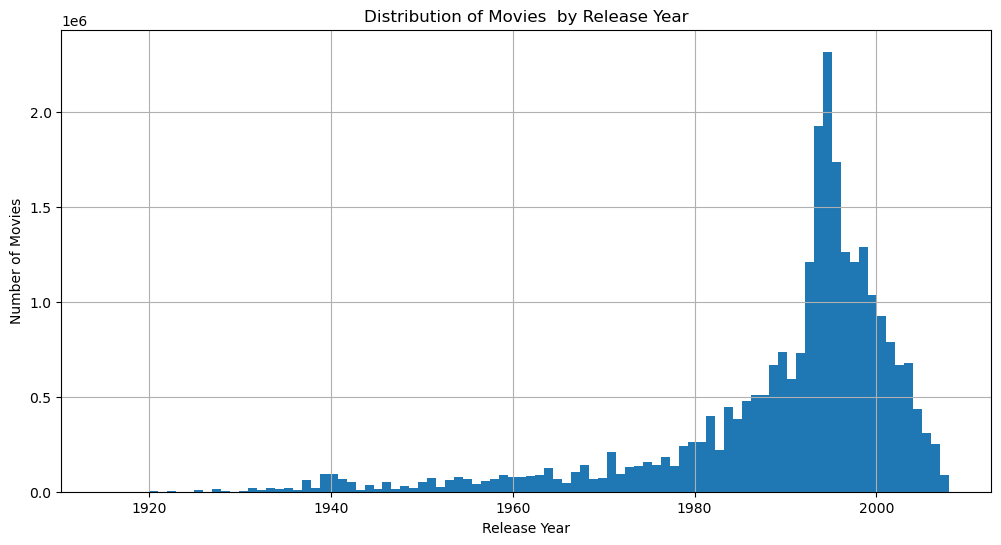

In [15]:
#Analyse distribution of movie releases based on year

#Get release date usuing a function called extract_year to separate title from release year
def extract_year(title):
    match = re.search(r'\((\d{4})\)', title)
    if match:
        return match.group(1)
    return None


#Call function and add a new column to store value of release year
movielens_updated['Release_Year']= movielens_updated['title'].apply(extract_year).astype(int)

# Create a histogram
plt.figure(figsize=(12, 6))
movielens_updated['Release_Year'].hist(bins=movielens_updated['Release_Year'].nunique())
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies  by Release Year')

#Display chart
plt.show()


In [16]:
#Process the timestamp column for analyis and modeling purposes
#Extract year, day and month


# Define a custom function to convert Unix timestamp to datetime
def unix_to_datetime(timestamp):
    return datetime.datetime.fromtimestamp(timestamp)

# Apply the custom function to the 'timestamp' column
movielens_updated['timestamp'] = movielens_updated['timestamp'].apply(unix_to_datetime)


# Create new columns for day, month, and year by separating the 'timestamp' column
movielens_updated['day'] = movielens_updated['timestamp'].dt.day
movielens_updated['month'] = movielens_updated['timestamp'].dt.month
movielens_updated['year'] = movielens_updated['timestamp'].dt.year

movielens_updated.head(5)

,userId,movieId,rating,timestamp,title,genres,rounded_rates,Release_Year,day,month,year
0,1,122,5.0,1996-08-02 13:24:06,Boomerang (1992),Comedy,5,1992,2,8,1996
0,1,122,5.0,1996-08-02 13:24:06,Boomerang (1992),Romance,5,1992,2,8,1996
1,139,122,3.0,2000-11-15 17:37:01,Boomerang (1992),Comedy,3,1992,15,11,2000
1,139,122,3.0,2000-11-15 17:37:01,Boomerang (1992),Romance,3,1992,15,11,2000
2,149,122,2.5,2005-04-01 09:58:42,Boomerang (1992),Comedy,2,1992,1,4,2005


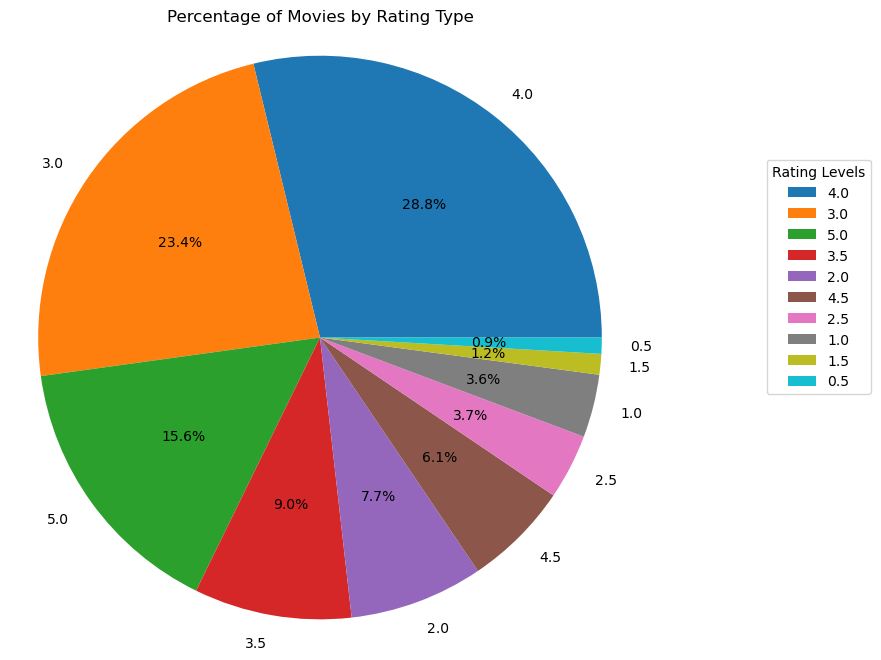

In [17]:
#Ratings analysis to show how many movies were rated under each rating level

# Count the number of movies under each rating type
movielens_rating_counts = movielens_updated['rating'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(movielens_rating_counts, labels=movielens_rating_counts.index, autopct='%1.1f%%')
plt.title('Percentage of Movies by Rating Type')
plt.axis('equal')

#show legend
plt.legend(movielens_rating_counts.index, title='Rating Levels', loc='upper right', bbox_to_anchor=(1.4, 0.8))

#Display chart
plt.show()

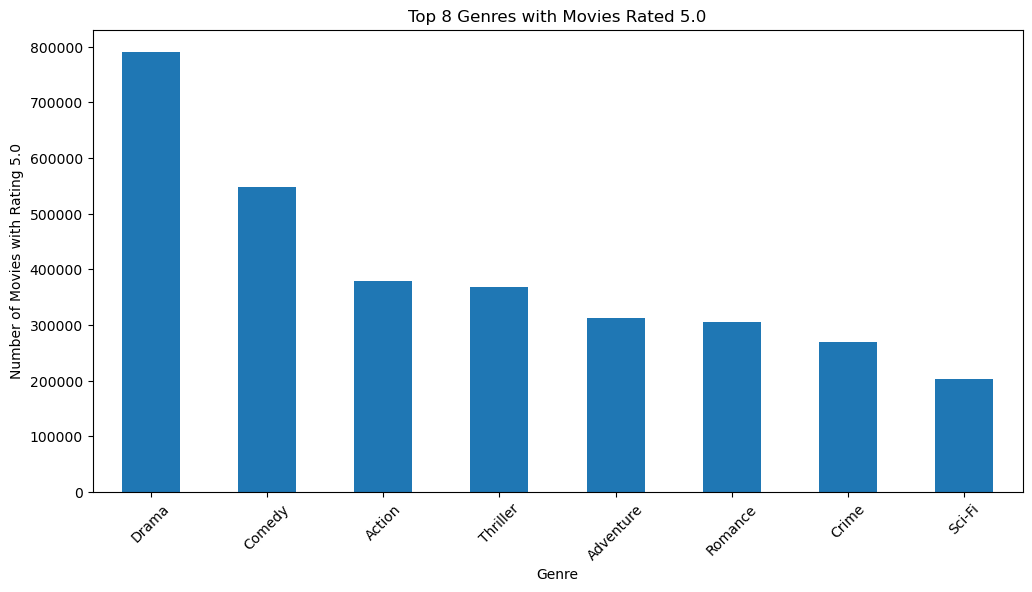

In [18]:
#Genres analysis to see which genres recieved most high ratings

# Filter the dataframe to only include movies with a rating of 5.0
high_rated_movies = movielens_updated[movielens_updated['rating'] == 5.0]

# Count the number of movies in each genre with a rating of 5.0
genre_counts = high_rated_movies['genres'].value_counts().nlargest(8)

# Create the bar graph
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Number of Movies with Rating 5.0')
plt.title('Top 8 Genres with Movies Rated 5.0')
plt.xticks(rotation=45)
plt.show()

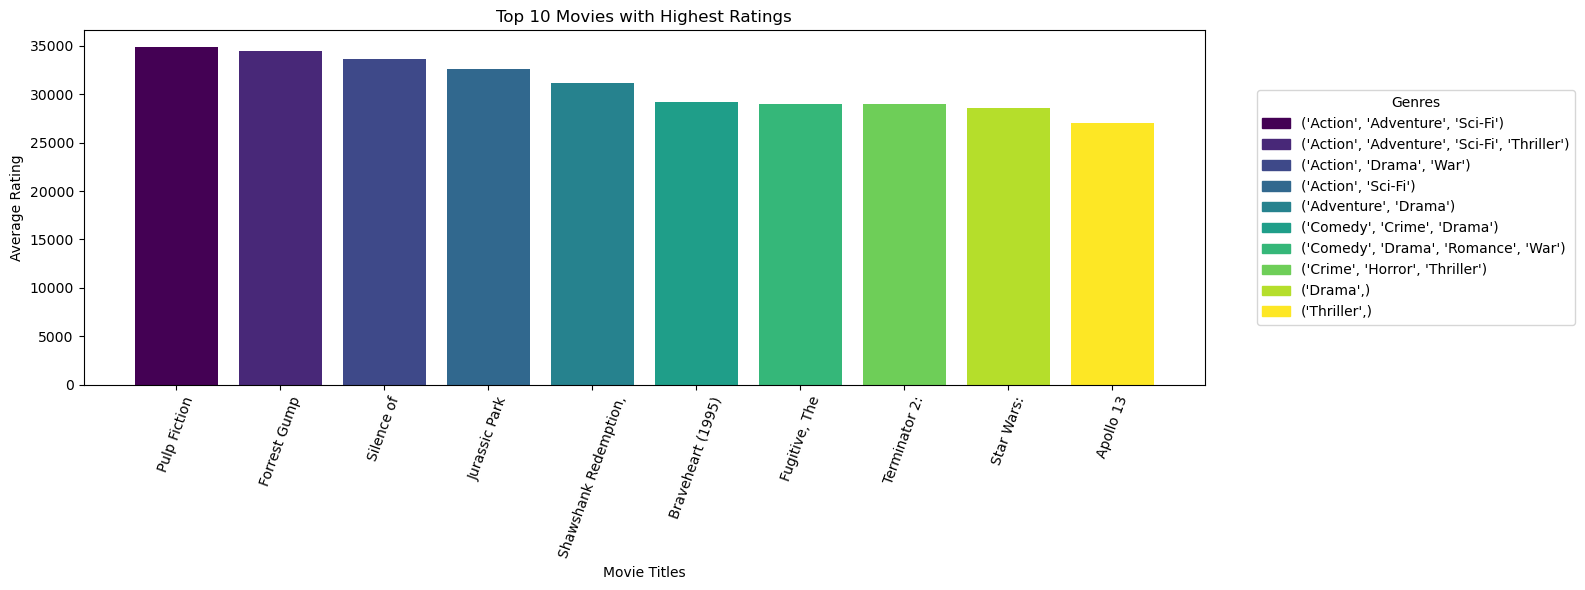

In [19]:
#Analysis of the top 10 greatest movies with most ratings and the genres they belong to

# Ratings are grouped by movie title and average rating is calculated for each and only the top 10 is selected.
movie_ratings = movielens.groupby('title')['rating'].count().nlargest(10)


# Becuase  the movie names are too long, we extract the first two words of the movie titles
#Also selected the genre that each movie belongs to
title_words = [' '.join(title.split()[:2]) for title in movie_ratings.index]
# genres = [movielens.loc[movielens['title'] == title, 'genres'].values[0]
#           for title in movie_ratings.index]

genres = [tuple(movielens.loc[movielens['title'] == title, 'genres'].values[0]) for title in movie_ratings.index]

# Create the  bar graph
fig, ax = plt.subplots(figsize=(16, 6))
bars = ax.bar(range(len(movie_ratings)), movie_ratings.values, color=[plt.cm.viridis(i/float(len(movie_ratings)-1))
                                                                      for i in range(len(movie_ratings))])
ax.set_xticks(range(len(movie_ratings)))
ax.set_xticklabels(title_words, rotation=70)
ax.set_xlabel('Movie Titles')
ax.set_ylabel('Average Rating')
ax.set_title('Top 10 Movies with Highest Ratings')

# Add the legend
legend_labels = sorted(set(genres))
legend_handles = [plt.Rectangle((0,0),1,1, color=plt.cm.viridis(i/float(len(legend_labels)-1))) for i in range(len(legend_labels))]
ax.legend(legend_handles, legend_labels, title='Genres', loc='center left', bbox_to_anchor=(1.04, 0.5), fontsize='medium')

plt.tight_layout()
plt.show()

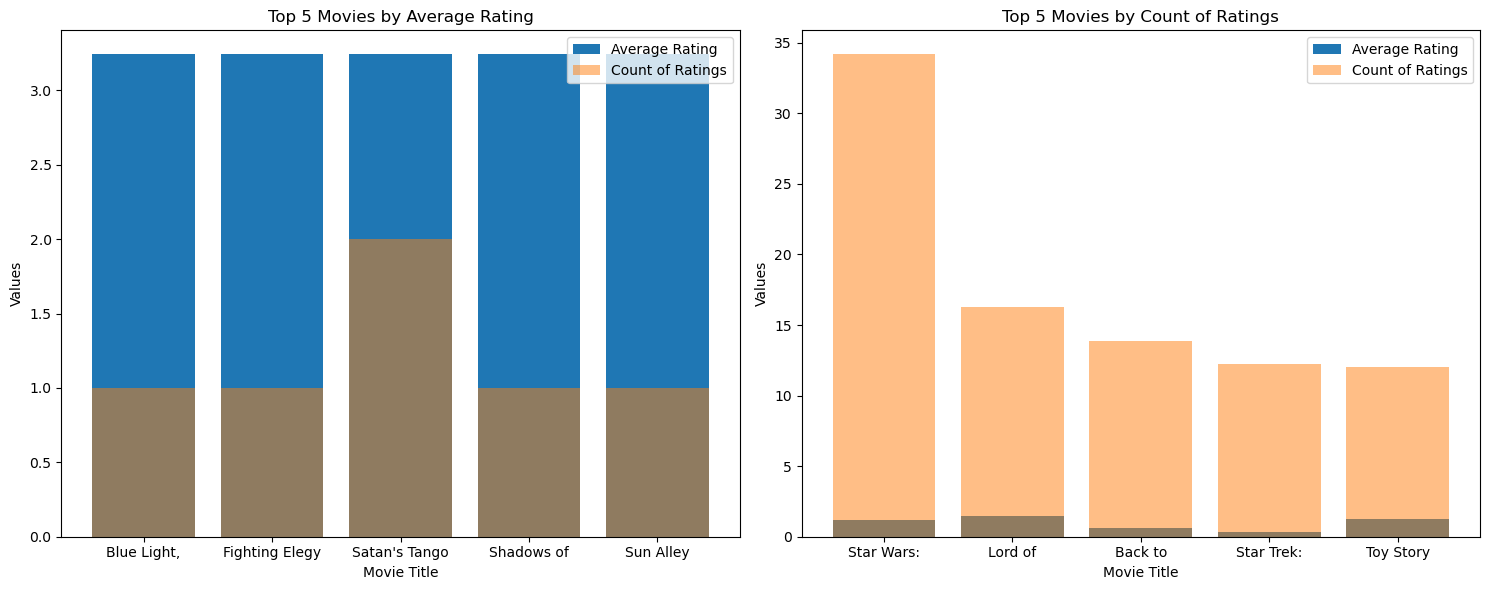

In [76]:
"""Analysis of movie populariy based on number of user ratings and the type of ratings given. This analysis
looks at both the count of movie ratings and the average rating per each movie. The aim of the analysis 
is to ascertain that a good movie should have a higher rating and should been rated/watched by many."""


#Step 1:We extract the first two words for movie name to shorten the name
movielens['short_title'] = movielens['title'].apply(lambda x: ' '.join(x.split()[:2]))

#Step 2: we calculate the average rating and count ratings for each movie
movie_stats =movie_ratings = movielens.groupby('short_title')['rating'].agg(['mean', 'count']).reset_index()
movie_stats.columns=['short_title', 'avg_rating', 'count_rating']

#Step 3: we normalize the values usuing a standardScaler so that they can be assesed usuing same visiualizations
scaler = StandardScaler() 
movie_stats[['avg_rating_scaled', 'count_rating_scaled']] = scaler.fit_transform(
    movie_stats[['avg_rating', 'count_rating']])


#Step 4: We get the top 5 by average rating and count of ratings
top_5_avg_rating = movie_stats.nlargest(5, 'avg_rating_scaled')
top_5_count_rating = movie_stats.nlargest(5, 'count_rating_scaled')


#Step 5:Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Top 5 by average rating
axes[0].bar(top_5_avg_rating['short_title'], top_5_avg_rating['avg_rating_scaled'], label='Average Rating')
axes[0].bar(top_5_avg_rating['short_title'], top_5_avg_rating['count_rating'], label='Count of Ratings',
            alpha=0.5)
axes[0].set_title('Top 5 Movies by Average Rating')
axes[0].set_xlabel('Movie Title')
axes[0].set_ylabel('Values')
axes[0].legend()

# Top 5 by count of ratings
axes[1].bar(top_5_count_rating['short_title'], top_5_count_rating['avg_rating_scaled'], label='Average Rating')
axes[1].bar(top_5_count_rating['short_title'], top_5_count_rating['count_rating_scaled'], label='Count of Ratings',
            alpha=0.5)
axes[1].set_title('Top 5 Movies by Count of Ratings')
axes[1].set_xlabel('Movie Title')
axes[1].set_ylabel('Values')
axes[1].legend()

plt.tight_layout()
plt.show()


### Step 3:Data Preprocessing 

In this section features and target varibales will be selected.

**Features/Predictors**
- Title of movie          
- Movie release date based on the title column  
- Year  based on timestamp column 
- Gener

**Target Variable**
- rating, what we intend to predict   

In [20]:
# Convert categorical variables to numerical for processing usuing standard scaler
encoded_columns = []
for column in movielens_updated.columns:
    if movielens_updated[column].dtype == 'object':  # Check if the column is categorical
        frequency_map = movielens_updated[column].value_counts(normalize=True)
        encoded_column = column + '_encoded'
        movielens_updated[encoded_column] = movielens_updated[column].map(frequency_map)
        encoded_columns.append(encoded_column)

# Print the encoded new movielens dataframe
movielens_updated.head(5)

,userId,movieId,rating,timestamp,title,genres,rounded_rates,Release_Year,day,month,year,title_encoded,genres_encoded
0,1,122,5.0,1996-08-02 13:24:06,Boomerang (1992),Comedy,5,1992,2,8,1996,0.000186,0.151501
0,1,122,5.0,1996-08-02 13:24:06,Boomerang (1992),Romance,5,1992,2,8,1996,0.000186,0.073242
1,139,122,3.0,2000-11-15 17:37:01,Boomerang (1992),Comedy,3,1992,15,11,2000,0.000186,0.151501
1,139,122,3.0,2000-11-15 17:37:01,Boomerang (1992),Romance,3,1992,15,11,2000,0.000186,0.073242
2,149,122,2.5,2005-04-01 09:58:42,Boomerang (1992),Comedy,2,1992,1,4,2005,0.000186,0.151501


In [21]:
#Created a new dataframe based on total ratings usuing feature variables for improved model perfomance
#Grouping simplifies the model by reducing complexity and increase chance of capturing essential patterns

rates_counts = movielens_updated.groupby(['Release_Year','title_encoded','genres_encoded'
                                         ,'year'])['rating'].sum().reset_index()


# Display the updated DataFrame
rates_counts.head(5)

,Release_Year,title_encoded,genres_encoded,year,rating
0,1915,0.000016,0.021876,2003,88.0
1,1915,0.000016,0.021876,2004,237.0
2,1915,0.000016,0.021876,2005,149.5
3,1915,0.000016,0.021876,2006,79.0
4,1915,0.000016,0.021876,2007,55.5


In [22]:
# Selected numeric variables to be scaled. Model perfoms better if scaled data is used. 

numeric_columns = ['Release_Year','rating','genres_encoded','title_encoded','year']

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the selected columns and transform the data
movielens_scaled = rates_counts.copy()  # Create a copy of the original DataFrame
movielens_scaled[numeric_columns] = scaler.fit_transform(movielens_scaled[numeric_columns])

# Print the resulting scaled DataFrame
movielens_scaled

,Release_Year,title_encoded,genres_encoded,year,rating
0,-4.062680,-0.418596,-1.439249,-0.365551,-0.312618
1,-4.062680,-0.418596,-1.439249,-0.064799,-0.222281
2,-4.062680,-0.418596,-1.439249,0.235954,-0.275331
3,-4.062680,-0.418596,-1.439249,0.536706,-0.318075
4,-4.062680,-0.418596,-1.439249,0.837458,-0.332323
...,...,...,...,...,...
151720,1.208108,0.313256,-0.806765,1.438963,-0.163774
151721,1.208108,0.313256,0.148971,1.138211,6.196825
151722,1.208108,0.313256,0.148971,1.438963,-0.163774
151723,1.208108,0.313256,1.194294,1.138211,6.196825


### Step 4: Feature Selection and Engineering

In [23]:
#Used correlation matrix table to choose variables and to make sure correlation socres are within expected levels

#Select only numerical columns for correlation analysis
movielens_scaled_nu= movielens_scaled.select_dtypes(include=[np.number])

#call the correlation function usuing the dataframe (movielens_scaled_nu) with numericals only
corr_matrix = movielens_scaled_nu.corr()

#show correlation table
corr_matrix


,Release_Year,title_encoded,genres_encoded,year,rating
Release_Year,1.000000,0.074761,0.079621,0.029095,0.068185
title_encoded,0.074761,1.000000,-0.084928,-0.126246,0.613211
genres_encoded,0.079621,-0.084928,1.000000,-0.016339,-0.029587
year,0.029095,-0.126246,-0.016339,1.000000,-0.217653
rating,0.068185,0.613211,-0.029587,-0.217653,1.000000


Select variables for X and y.  X variables being the predictors and y variable being the target

In [24]:
#select movie release year, the movieId for identification,the title of the movie,  genre, year and month of rating
#X =  movielens_scaled[['Release_Year','movieId','title_encoded','genres_encoded','year','month']]
X =  movielens_scaled[['Release_Year','title_encoded','genres_encoded','year']]


#Show x variables
X.head(2)

,Release_Year,title_encoded,genres_encoded,year
0,-4.06268,-0.418596,-1.439249,-0.365551
1,-4.06268,-0.418596,-1.439249,-0.064799


In [25]:
#Select the target variable which is the ratings column that the model will predict
y =  movielens_scaled['rating']

#show target variable
y.head(2)

0   -0.312618
1   -0.222281
Name: rating, dtype: float64

In [26]:
#Split  training and validation sets (10%). The validaion will be used at the end for final evaluation.
X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.1,
                                                random_state=142) #varible temp is for training and testing

print( X_temp.shape )
print( X_val.shape )
print( y_temp.shape )
print( y_val.shape )


(136552, 4)
(15173, 4)
(136552,)
(15173,)


In [27]:
#Split the training dataset into test data (10%) and train data 90% of the training data
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=142)

#Check shapes of train and test data

print( X_train.shape )
print( X_test.shape )
print( y_train.shape )
print( y_test.shape )

(122896, 4)
(13656, 4)
(122896,)
(13656,)


### Step 5:Model selection and Training

In [28]:
# Create a linear regression model and use cross validation on the training dataset to asses model performance
model = LinearRegression()
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("Cross-Validation RMSE:", np.mean(-cv_scores))

# Fit the model with the training data
model.fit(X_train, y_train)



Cross-Validation RMSE: 0.7618743904749534


LinearRegression()

In [29]:
# Evaluated the model usuing the internal test set
y_pred_test = model.predict(X_test)
print("Internal Test Set RMSE:", mean_squared_error(y_test, y_pred_test, squared=False))

Internal Test Set RMSE: 0.8642642657695563


### Step 6: Model Evaluation

In [30]:
#We evaluate the model usuing the validation dataset which is 10% of the original dataset
y_pred_val = model.predict(X_val)
print("Validation Set RMSE:", mean_squared_error(y_val, y_pred_val, squared=False))

Validation Set RMSE: 0.80747612873746
